In [1]:
# Load data
import numpy as np
import torch
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
from functions import Config
from models import GNNChoiceModel, MNL_Choice
from data_process import load_data, spatial_choice_dataset_interact
import matplotlib.cm as cm
import matplotlib.colors as mcolors
device = torch.device("cpu")

plt.rcParams["font.family"] = "Helvetica"
plt.rcParams["axes.xmargin"] = 0.01
plt.rcParams["axes.ymargin"] = 0.01


comm, hh, edge_index, distance_to_work = load_data()

comm_features = [
    "pop_density",
    "white_prop",
    "black_prop",
    "single_res",
    "multi_res",
    "office",
    "land_mix",
    "transit_a_scaled",
    "med_house_age_scaled",
    "med_value_scaled",
    "h_units_scaled",
    "median_inc_scaled",
]


hh_features = ["hh_income_scaled", "race_white", "race_black"]

# Load dataset
my_dataset = spatial_choice_dataset_interact

i = 0
test_idx = np.arange(i, len(hh), 10)
train_idx = np.setdiff1d(np.arange(len(hh)), test_idx)
train_dataset = my_dataset(
    comm, hh.loc[train_idx, :], distance_to_work[train_idx], comm_features, hh_features
)
test_dataset = my_dataset(
    comm, hh.loc[test_idx, :], distance_to_work[test_idx], comm_features, hh_features
)
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=len(train_dataset), shuffle=True
)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=len(test_dataset), shuffle=False
)

feature_names = train_dataset.feature_names
# feature_names = comm_features + ["distance_to_work"] + hh_features
dataset = test_dataset
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=len(dataset), shuffle=False
)

## Interpretation of the MNL model

In [2]:
model = MNL_Choice(train_dataset[0][0].shape[-1], train_dataset[0][0].shape[0]).to(
    device
)
# Load the pretrained model state
model.load_state_dict(torch.load("log/Deepchoice_MNL_2025-03-16_12-17-54.pth"))

x, y = next(iter(train_loader))  # Get a batch of data
model.get_param_std(x, y)  # Get the standard errors of the parameters
significance = model.significance_test(x, y)  # Perform significance test

# Rename the index of significance DataFrame for better readability
new_index = significance.index.to_list()
new_index[: len(train_dataset.feature_names)] = train_dataset.feature_names
significance.index = new_index
print(significance.head(15))

                        params   std_err   t_values      p_values
pop_density           2.340572  0.136678  17.124681  0.000000e+00
single_res           -0.801881  0.141808  -5.654679  1.691679e-08
multi_res             0.581036  0.076141   7.631002  3.019807e-14
office                0.106676  0.019458   5.482501  4.502635e-08
land_mix             -0.943784  0.105384  -8.955638  0.000000e+00
transit_a_scaled     -1.472552  0.182040  -8.089178  8.881784e-16
med_house_age_scaled  0.782751  0.108138   7.238417  5.597744e-13
med_value_scaled     -0.321585  0.111050  -2.895853  3.805665e-03
h_units_scaled        1.971927  0.104562  18.858952  0.000000e+00
distance_to_work     -0.908250  0.041981 -21.635027  0.000000e+00
home_income_interact -0.874757  0.153463  -5.700103  1.300550e-08
white_interact        2.811741  0.227796  12.343266  0.000000e+00
black_interact        4.001101  0.199859  20.019625  0.000000e+00
asc_0                -0.174264  0.141287  -1.233406  2.175104e-01
asc_1     

## Interpretation of the GNN model

In [3]:
# Load GNN model
device = torch.device("cpu")
config = Config()
config.bs = 32
config.num_hidden = 64
config.dropout = 0
config.model = "GATConv"
config.heads = 4  # Number of attention heads for GAT
config.residual = True
config.seed = 100

gnn2 = GNNChoiceModel(
    train_dataset[0][0].shape[-1],
    config.num_hidden,
    edge_index,
    dropout=config.dropout,
    heads=config.heads,
    residual=config.residual,
    n_layer=2,
)
gnn2.load_state_dict(torch.load("log/Deepchoice_GATConv_2025-03-16_11-43-35.pth"))

<All keys matched successfully>

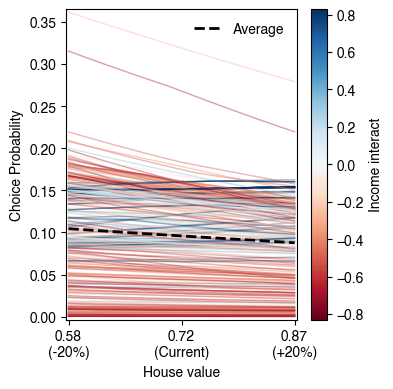

In [4]:
# For the north side, I will choose LAKE VIEW, id=5, median_inc=80k+, white_prop=85%, counts=373
comm_id = 5
main_factor = "med_value_scaled"
second_factor = "home_income_interact"
scope = 0.20  # 10% of the range
n = 10  # number of points to test on one side
main_idx = feature_names.index(main_factor)
second_idx = feature_names.index(second_factor)

results = []
inputs, target = next(iter(data_loader))  # inputs: (bs, num_comm, num_features)
first_factor_data = inputs[:, comm_id, main_idx].clone()
second_factor_data = inputs[:, comm_id, second_idx].cpu().detach().numpy()
for x in np.linspace(1 - scope, 1 + scope, 2 * n - 1):
    inputs[:, comm_id, main_idx] = first_factor_data * x
    outputs = gnn2(inputs).cpu().detach().numpy()  # (bs, num_comm)
    results.append(outputs[:, comm_id])

results = np.array(results)  # (2*n-1, bs)
results = np.exp(results)

vmax = min(1, max(abs(max(second_factor_data)), abs(min(second_factor_data))))
# Normalize the income values to a range suitable for colormap
norm = mcolors.Normalize(vmin=-vmax, vmax=vmax)
colormap = cm.RdBu  # Choose a colormap (e.g., viridis, plasma, etc.)
fig, ax = plt.subplots(figsize=(4, 4))
current_value = first_factor_data[i].item()
for i in range(second_factor_data.shape[0]):
    ax.plot(
        np.linspace(-1, 1, 2 * n - 1),
        results[:, i],
        color=colormap(norm(second_factor_data[i])),
        alpha=0.4,
        linewidth=1,
    )
ax.plot(
    np.linspace(-1, 1, 2 * n - 1),
    results.mean(axis=1),
    color="Black",
    linewidth=2,
    linestyle="--",
    label="Average",
)
ax.set_xlabel("House value")
ax.set_ylabel("Choice Probability")
ax.legend(frameon=False)
ax.set_xticks([-1, 0, 1])
ax.set_xticklabels(
    [
        f"{current_value * (1 - scope):.2f}\n(-{scope * 100:.0f}%)",
        f"{current_value:.2f}\n(Current)",
        f"{current_value * (1 + scope):.2f}\n(+{scope * 100:.0f}%)",
    ]
)

# Add a colorbar for reference
sm = cm.ScalarMappable(cmap=colormap, norm=norm)
sm.set_array([])
fig.colorbar(sm, ax=ax, label="Income interact")
fig.tight_layout()
fig.savefig("Lake_view_house_value.pdf")

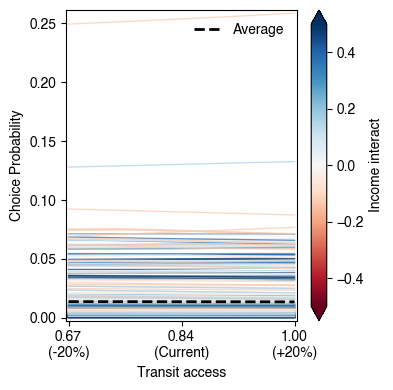

In [5]:
# For the south side, I will choose SOUTH SHORE, id=42, median_inc=24k+, white_prop=3.2%, black_prop=94%, counts=48
comm_id = 42
main_factor = "transit_a_scaled"
second_factor = "home_income_interact"
scope = 0.20  # 10% of the range
n = 10  # number of points to test on one side
main_idx = feature_names.index(main_factor)
second_idx = feature_names.index(second_factor)

results = []
inputs, target = next(iter(data_loader))  # inputs: (bs, num_comm, num_features)
first_factor_data = inputs[:, comm_id, main_idx].clone()
second_factor_data = inputs[:, comm_id, second_idx].cpu().detach().numpy()
for x in np.linspace(1 - scope, 1 + scope, 2 * n - 1):
    inputs[:, comm_id, main_idx] = first_factor_data * x
    outputs = gnn2(inputs).cpu().detach().numpy()  # (bs, num_comm)
    results.append(outputs[:, comm_id])

results = np.array(results)  # (2*n-1, bs)
results = np.exp(results)

# Normalize the income values to a range suitable for colormap
# vmax = min(1, max(abs(max(second_factor_data)), abs(min(second_factor_data))))
vmax = 0.5
norm = mcolors.Normalize(vmin=-vmax, vmax=vmax)
colormap = cm.RdBu  # Choose a colormap (e.g., viridis, plasma, etc.)
fig, ax = plt.subplots(figsize=(4, 4))
current_value = first_factor_data[1].item()
for i in range(second_factor_data.shape[0]):
    ax.plot(
        np.linspace(-1, 1, 2 * n - 1),
        results[:, i],
        color=colormap(norm(second_factor_data[i])),
        alpha=0.7,
        linewidth=1,
    )
ax.plot(
    np.linspace(-1, 1, 2 * n - 1),
    results.mean(axis=1),
    color="Black",
    linewidth=2,
    linestyle="--",
    label="Average",
)

ax.set_xlabel("Transit access")
ax.set_ylabel("Choice Probability")
ax.legend(frameon=False)
ax.set_xticks([-1, 0, 1])
# ax.set_ylim(0, 0.11)
ax.set_xticklabels(
    [
        f"{current_value * (1 - scope):.2f}\n(-{scope * 100:.0f}%)",
        f"{current_value:.2f}\n(Current)",
        f"{current_value * (1 + scope):.2f}\n(+{scope * 100:.0f}%)",
    ]
)

# Add a colorbar for reference
sm = cm.ScalarMappable(cmap=colormap, norm=norm)
sm.set_array([])
fig.colorbar(sm, ax=ax, label="Income interact", extend="both")
fig.tight_layout()
fig.savefig("South_shore_transit.pdf")